# WAVY Dataset generator

### Setup

/Users/aldric-l/Library/Python/3.11/lib/python/site-packages/torch_geometric/typing.py:128: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/aldric-l/Library/Python/3.11/lib/python/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalINS6_17basic_string_viewIcNS6_11char_traitsIcEEEEEE
  Referenced from: <2BF76774-0954-3F15-B7FE-8A5E5111D7DF> /Users/aldric-l/Library/Python/3.11/lib/python/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <A51C8C05-245A-3989-8D3C-9A6704422CA5> /Users/aldric-l/Library/Python/3.11/lib/python/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/aldric-l/Library/Python/3.11/lib/python/site-packages/torch_geometric/typing.py:166: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: dlopen(/

Generated 500 wavy surface vectors in R^20:
[[ 1.21405392 -0.84788846 -1.08625964  0.38712821  0.18305536  0.21402198
   0.91361268 -0.66129543 -1.46692654  0.85910053  1.12088359 -0.67098999
  -0.19340913  0.17389245 -0.54300187  0.48315665  0.80463038 -1.0264996
  -0.62123488  1.27763757]
 [ 0.53863805  0.96729506  0.64102996  0.94680311  0.73330701  0.9015937
   0.82479713  0.85992911  0.90909986  0.83684232  0.98637006  0.7936114
   1.06501628  0.75017443  1.14469718  0.69518772  1.19259289  0.6224864
   1.26624973  0.57627749]
 [ 1.11655061  0.27108775 -1.12383147 -1.60805383  0.88048518  1.11768162
  -0.4042365   0.63861006 -0.15182088 -1.36396259  0.69821164  0.4040085
  -1.13185892  0.48815266  1.30201416 -0.11511418 -1.14974147 -0.4880759
   0.73462293 -0.1767466 ]
 [ 0.69769676 -0.72058111  0.53361946  0.33780551  0.9916387   0.14251571
  -0.55774121 -0.56304029 -1.25365334  0.93320649 -0.13213783 -1.20169477
  -0.02383351  1.34823408  1.0242977  -1.31483496  0.97485886  1.10

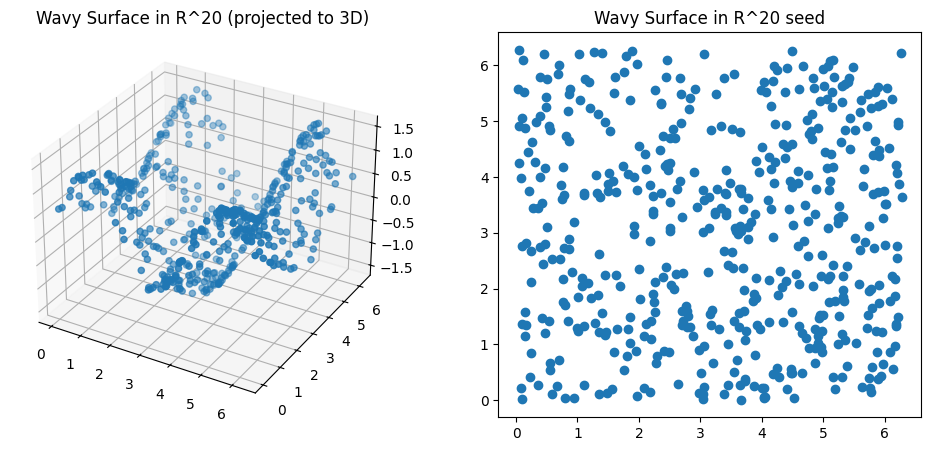

In [1]:
import numpy as np
import torch
from torch_geometric.data import Data, DataLoader


def generate_n_dim_vectors(num_points, n_dimensions, mapping_function, u_range=(0.0, 1.0), v_range=(0.0, 1.0)):
    """
    Generates n-dimensional vectors that lie on a 2D manifold.

    The 2D manifold is defined by a 'mapping_function' f(u, v) -> R^n.
    This function generates 'num_points' by sampling 'u' and 'v' uniformly
    from their respective ranges and applying the mapping function.

    Args:
        num_points (int): The number of n-dimensional vectors to generate.
        n_dimensions (int): The dimension (n) of the ambient space (R^n).
                            Must be at least 2.
        mapping_function (callable): A function that defines the 2D manifold.
                                     It must accept three arguments:
                                     - u_coords (1D numpy.ndarray): Array of u-coordinates.
                                     - v_coords (1D numpy.ndarray): Array of v-coordinates.
                                     - n_dimensions (int): The target ambient dimension.
                                     It must return a numpy.ndarray of shape
                                     (num_points, n_dimensions).
        u_range (tuple, optional): A tuple (min_u, max_u) defining the range
                                   for the 'u' parameter. Defaults to (0.0, 1.0).
        v_range (tuple, optional): A tuple (min_v, max_v) defining the range
                                   for the 'v' parameter. Defaults to (0.0, 1.0).

    Returns:
        numpy.ndarray: An array of shape (num_points, n_dimensions)
                       containing the generated n-dimensional vectors.

    Raises:
        ValueError: If n_dimensions is less than 2, or if the mapping function
                    returns an array of the wrong shape.
    """
    if n_dimensions < 2:
        raise ValueError("n_dimensions must be at least 2 to embed a 2D manifold.")

    # Generate random u and v coordinates within the specified ranges
    u_coords = np.random.uniform(u_range[0], u_range[1], num_points)
    v_coords = np.random.uniform(v_range[0], v_range[1], num_points)

    # Apply the mapping function to get the n-dimensional vectors
    n_dim_vectors = mapping_function(u_coords, v_coords, n_dimensions)

    # Validate the output shape of the mapping function
    if n_dim_vectors.shape != (num_points, n_dimensions):
        raise ValueError(
            f"Mapping function must return an array of shape ({num_points}, {n_dimensions}). "
            f"Got {n_dim_vectors.shape} instead."
        )

    return n_dim_vectors, u_coords, v_coords

# --- Example Mapping Functions to define different 2D Manifolds ---

def planar_patch_mapping(u_coords, v_coords, n_dimensions):
    """
    Defines a simple planar patch embedded in R^n.
    The first two dimensions are directly mapped to u and v,
    and higher dimensions are linear combinations or zeros.
    """
    num_points = len(u_coords)
    vectors = np.zeros((num_points, n_dimensions))

    # Define two linearly independent direction vectors in R^n for the plane
    # For a simple and deterministic example:
    dir1 = np.zeros(n_dimensions)
    dir1[0] = 1.0  # u-axis direction
    if n_dimensions > 2:
        dir1[2] = 0.5 # Adds a slight tilt in the 3rd dimension

    dir2 = np.zeros(n_dimensions)
    dir2[1] = 1.0  # v-axis direction
    if n_dimensions > 3:
        dir2[3] = -0.3 # Adds a slight tilt in the 4th dimension

    # An origin point for the plane (can be np.zeros(n_dimensions))
    origin = np.full(n_dimensions, 0.1) # Slightly offset from origin for illustration

    for i in range(num_points):
        vectors[i, :] = origin + u_coords[i] * dir1 + v_coords[i] * dir2
    return vectors

def wavy_surface_mapping(u_coords, v_coords, n_dimensions):
    """
    Defines a wavy, non-linear surface embedded in R^n.
    The first two dimensions are u and v, and subsequent dimensions
    are determined by trigonometric functions of u and v.
    """
    num_points = len(u_coords)
    vectors = np.zeros((num_points, n_dimensions))

    #vectors[:, 0] = u_coords  # First dimension is u
    #vectors[:, 1] = v_coords  # Second dimension is v

    # Define the remaining dimensions based on u and v to create curvature
    for i in range(0, n_dimensions):
        if i % 2 == 0:
            vectors[:, i] = np.sin(u_coords * (i + 1) / 2) + np.cos(v_coords * (i + 1) / 3) * 0.5
        else:
            vectors[:, i] = np.cos(u_coords * (i + 1) / 3) - np.sin(v_coords * (i + 1) / 2) * 0.7
    return vectors

def sphere_like_mapping(u_coords, v_coords, n_dimensions, radius=1.0):
    """
    Generates points on a sphere-like surface, suitable for R^n where n >= 3.
    u_coords and v_coords are typically angles (e.g., from 0 to 2*pi).
    For n=3, it creates a standard sphere. For n > 3, it projects the sphere
    onto the first 3 dimensions and adds higher dimensions.
    """
    num_points = len(u_coords)
    vectors = np.zeros((num_points, n_dimensions))

    if n_dimensions < 3:
        raise ValueError("n_dimensions must be at least 3 for a sphere-like manifold.")

    # Standard spherical coordinates mapping to R^3
    # u_coords (theta) typically 0 to pi, v_coords (phi) typically 0 to 2*pi
    # Adjust ranges in generate_n_dim_vectors for correct sampling
    x = radius * np.sin(u_coords) * np.cos(v_coords)
    y = radius * np.sin(u_coords) * np.sin(v_coords)
    z = radius * np.cos(u_coords)

    vectors[:, 0] = x
    vectors[:, 1] = y
    vectors[:, 2] = z

    # For n > 3, define the remaining dimensions
    # These dimensions are still functions of u and v, ensuring it's a 2D manifold
    for i in range(3, n_dimensions):
        vectors[:, i] = np.sin(u_coords * (i - 1)) * np.cos(v_coords * i) * 0.2
    return vectors

def add_noise(vectors, u_coords=None, v_coords=None, noise_level=0.01):
    """
    Adds isotropic Gaussian noise to each point in the dataset.
    
    Args:
        vectors (numpy.ndarray): Array of shape (num_points, n_dimensions).
        noise_level (float): Standard deviation of Gaussian noise.
    
    Returns:
        numpy.ndarray: Noisy data.
    """
    noise = np.random.normal(0, noise_level, vectors.shape)
    return vectors + noise if u_coords is None else vectors + noise, u_coords, v_coords

# Example 2: Generate points on a wavy surface in R^5
num_points_wavy = 500
n_dim_wavy = 20
wavy_vectors, u_coords, v_coords = add_noise(*generate_n_dim_vectors(
    num_points_wavy,
    n_dim_wavy,
    wavy_surface_mapping,
    u_range=(0.0, 2 * np.pi),
    v_range=(0.0, 2 * np.pi)
))
print(f"Generated {num_points_wavy} wavy surface vectors in R^{n_dim_wavy}:")
print(wavy_vectors[:5])
print(f"Shape: {wavy_vectors.shape}\n")

# To visualize (e.g., for n=3):
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(u_coords, v_coords, wavy_vectors[:,2])
ax.set_title(f'Wavy Surface in R^{n_dim_wavy} (projected to 3D)')

ax = fig.add_subplot(122)
ax.scatter(u_coords, v_coords)
ax.set_title(f'Wavy Surface in R^{n_dim_wavy} seed')
plt.show()
plt.show()


seed_vectors = np.stack([u_coords, v_coords], axis=-1)


# wavydata = Data(x=torch.tensor(wavy_vectors, dtype=torch.float), 
#                 edge_index=create_full_loops_edge_index(num_points_wavy),
#                 edge_labels=torch.tensor(np.ones_like(create_full_loops_edge_index(num_points_wavy))))




In [2]:
import numpy as np

def pad_and_merge_vectors(list_of_vectors_input, numpy_array_of_vectors):
    """
    Pads vectors in a list to match the size of vectors in a NumPy array,
    then merges them into a single NumPy array.

    Args:
        list_of_vectors_input (list or np.ndarray):
            A list where each inner list/array represents a vector, potentially of varying lengths.
            Can also be a 1D or 2D NumPy array itself.
        numpy_array_of_vectors (np.ndarray or None):
            A 2D NumPy array where each row is a vector of consistent size N, or None if no such array.

    Returns:
        np.ndarray: A single 2D NumPy array containing all padded and original vectors.
                    Returns an empty array if both inputs are effectively empty.
    """
    # Ensure list_of_vectors is always a Python list for consistent iteration
    if isinstance(list_of_vectors_input, np.ndarray):
        # If it's a NumPy array, convert it to a list of lists/arrays for individual processing
        list_of_vectors = list_of_vectors_input.tolist()
    else:
        list_of_vectors = list_of_vectors_input


    # --- Robustly check for empty inputs ---
    list_is_empty = not list_of_vectors # This is now safe as list_of_vectors is a Python list
    numpy_array_is_empty = (numpy_array_of_vectors is None or
                            numpy_array_of_vectors.size == 0 or
                            (isinstance(numpy_array_of_vectors, np.ndarray) and numpy_array_of_vectors.shape[0] == 0))


    if list_is_empty and numpy_array_is_empty:
        return np.array([]) # Return empty array if both inputs are empty or None

    # Determine the target length (N)
    target_N = 0
    if not numpy_array_is_empty:
        target_N = numpy_array_of_vectors.shape[1]
    elif not list_is_empty:
        # If the numpy array is empty, find the max length from the list of vectors
        # Ensure we can safely get length of elements in list_of_vectors
        if any(isinstance(v, (list, np.ndarray)) and len(v) > 0 for v in list_of_vectors):
             target_N = max(len(v) for v in list_of_vectors if isinstance(v, (list, np.ndarray)))
        else: # List contains only non-iterable or empty elements
             return np.array([])

        # Handle case where list only contains empty vectors or scalars
        if target_N == 0:
            # If all vectors in the list are empty or scalars, we still need a target_N.
            # If numpy_array_is_empty, and list_of_vectors are all empty, then return empty.
            # Otherwise, if numpy_array_of_vectors was not empty, target_N would be set.
            # This case means list_of_vectors has content but all are length 0.
            if not numpy_array_is_empty: # This condition should already be covered above
                pass
            else:
                return np.array([])


    # Prepare padded list vectors
    padded_list_vectors = []
    # Determine a suitable dtype, defaulting to float if no existing NumPy array
    output_dtype = numpy_array_of_vectors.dtype if not numpy_array_is_empty else float

    for vec in list_of_vectors:
        # Ensure vec is a numpy array for consistent handling, and handle scalars
        try:
            vec_np = np.array(vec, dtype=output_dtype)
        except ValueError: # Catches cases where vec might be a non-numeric scalar
            vec_np = np.array([vec], dtype=output_dtype)


        if vec_np.ndim == 0: # Handle scalar inputs in list (e.g., [1, 2, 3] if 1, 2, 3 were treated as separate items)
            vec_np = vec_np.reshape(1)

        if len(vec_np) < target_N:
            # Pad with zeros at the end
            padded_vec = np.pad(vec_np, (0, target_N - len(vec_np)), 'constant', constant_values=0)
        elif len(vec_np) > target_N:
            # If a vector in the list is longer than N, truncate it
            padded_vec = vec_np[:target_N]
        else:
            padded_vec = vec_np
        padded_list_vectors.append(padded_vec)

    # Convert the list of padded vectors to a NumPy array
    # Ensure it's a 2D array even if padded_list_vectors is empty
    # Handle the case where target_N might still be 0 if all vectors are scalars or empty.
    if len(padded_list_vectors) > 0:
        # If there are actual vectors, ensure they are consistently sized before stacking
        # This handles cases where target_N might have been 0 but elements exist
        final_list_array_elements = []
        for pv in padded_list_vectors:
            if pv.shape[0] < target_N:
                final_list_array_elements.append(np.pad(pv, (0, target_N - pv.shape[0]), 'constant', constant_values=0))
            elif pv.shape[0] > target_N:
                final_list_array_elements.append(pv[:target_N])
            else:
                final_list_array_elements.append(pv)
        padded_list_array = np.array(final_list_array_elements)
    else:
        padded_list_array = np.empty((0, target_N), dtype=output_dtype)


    # Merge the padded list vectors with the original numpy array vectors
    if padded_list_array.shape[0] == 0: # Only numpy_array_of_vectors has data or both were empty
        return numpy_array_of_vectors
    elif numpy_array_is_empty: # Only padded_list_array has data
        return padded_list_array
    else: # Both have data
        return np.vstack((padded_list_array, numpy_array_of_vectors))


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
def plot_correlogram(*correlation_matrices, titles=None, cmap='viridis', organ_names_dict=None, remove_diagonal=False, triangular=False, annot=False):
    """
    Plots multiple correlograms (NumPy arrays) in a row as subplots with a shared color scale and adjusted axis labels.

    Args:
        *correlation_matrices: Variable number of NumPy arrays (correlation matrices).
        titles: Optional list of titles for each correlogram. If None, default titles are used.
        cmap: Optional colormap for the heatmaps.
        organ_names_dict: Optional dictionary mapping indices to organ names. If provided, axis labels are adjusted.
    """

    num_matrices = len(correlation_matrices)

    if num_matrices == 0:
        print("No correlation matrices provided.")
        return

    if titles is None:
        titles = [f"Correlogram {i+1}" for i in range(num_matrices)]
    elif len(titles) != num_matrices:
        print("Number of titles does not match number of matrices.")
        titles = [f"Correlogram {i+1}" for i in range(num_matrices)]

    # Find the global min and max for the color scale
    global_min = min(np.nanmin(corr_matrix) for corr_matrix in correlation_matrices)
    global_max = max(np.nanmax(corr_matrix) for corr_matrix in correlation_matrices)

    if num_matrices == 1:
        plt.figure(figsize=(8 + 2*(organ_names_dict is not None), 8 + 2*(organ_names_dict is not None)))
    else:
        plt.figure(figsize=(12 * num_matrices, 12))

    for i, corr_matrix in enumerate(correlation_matrices):
        if remove_diagonal:
            np.fill_diagonal(corr_matrix, np.nan)
        if triangular:
            mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        else:
            mask = False

        plt.subplot(1, num_matrices, i + 1)
        ax = sns.heatmap(
            corr_matrix,
            annot=annot,
            cmap=cmap,
            fmt='.2f',
            linewidths=0,
            cbar_kws={"shrink": 0.8},
            annot_kws={"size": 12},
            square=True,
            linecolor='white',
            vmin=global_min,  # Set global min
            vmax=global_max,   # Set global max
            mask=mask
        )
        plt.title(titles[i])

        if organ_names_dict is not None:
            num_organs = corr_matrix.shape[0]
            if len(organ_names_dict) == num_organs:
                organ_names = [organ_names_dict.get(j, f"Index {j}") for j in range(num_organs)]
                ax.set_xticks(np.array(range(num_organs))+0.5)
                ax.set_xticklabels(organ_names, rotation=90)
                ax.set_yticks(np.array(range(num_organs))+0.5)
                ax.set_yticklabels(organ_names, rotation=0)
            else:
                print(f"Warning: Length of organ_names_dict ({len(organ_names_dict)}) does not match matrix size ({num_organs}).")

    plt.tight_layout()
    plt.show()
    return plt

### WAVY2

In [ ]:
np.mean(np.linalg.norm(wavy_vectors, axis=1))

np.float64(3.725843958184465)

In [ ]:
np.mean(np.linalg.norm(np.array(seed_vectors), axis=1))

np.float64(4.876562772870344)

In [ ]:
mixed_vectors = pad_and_merge_vectors(seed_vectors[range(0,150)], wavy_vectors[range(150,500)])

NameError: name 'pad_and_merge_vectors' is not defined

In [ ]:
true_comp_matrix = np.dot(np.array(seed_vectors), np.transpose(np.array(seed_vectors)))
true_comp_matrix /= np.max(true_comp_matrix)
fake_comp_matrix = (np.dot(wavy_vectors, np.transpose(wavy_vectors))**2)**0.2573729
fake_comp_matrix /= np.max(fake_comp_matrix)

mixed_comp_matrix = np.copy(fake_comp_matrix)
mixed_comp_matrix[0:350, 0:350] = true_comp_matrix[0:350, 0:350]

In [ ]:
np.sum(true_comp_matrix)

np.float64(67161.80238580712)

In [ ]:
np.sum(fake_comp_matrix)

np.float64(67161.81089128421)

In [ ]:
np.savetxt("wavy2_comp_matrix_partiallytrue.csv", mixed_comp_matrix, fmt='%.6f', delimiter=',')
np.savetxt("wavy2_p_matrix.csv", wavy_vectors, fmt='%.6f', delimiter=',')
np.savetxt("wavy2_true_p_matrix.csv", seed_vectors, fmt='%.6f', delimiter=',')

### WAVY3

In [ ]:
#np.savetxt("wavy3_comp_matrix.csv", np.dot(wavy_vectors, np.transpose(wavy_vectors)), fmt='%.6f', delimiter=',')
np.savetxt("wavy3_comp_matrix.csv", np.dot(seed_vectors, np.transpose(seed_vectors)), fmt='%.6f', delimiter=',')
np.savetxt("wavy3_p_matrix.csv", wavy_vectors, fmt='%.6f', delimiter=',')
np.savetxt("wavy3_true_p_matrix.csv", seed_vectors, fmt='%.6f', delimiter=',')

### WAVY4
The idea is to generate a globally homophilic dataset, with only 150 non homophilic nodes.


In [14]:
import random

def shuffle_symmetric_matrix(matrix: list[list[any]], k: int) -> list[list[any]]:
    """
    Shuffles the elements within the last k columns of a square matrix
    and propagates the changes to the corresponding rows to maintain symmetry.

    Args:
        matrix: A square matrix (list of lists) of any type.
        k: The number of last columns to shuffle.

    Returns:
        The modified symmetric matrix with the last k columns and
        corresponding rows shuffled.

    Raises:
        ValueError: If the matrix is not square or if k is an invalid value.
    """
    matrix = np.copy(matrix)
    try:
        n = len(matrix)
        if n == 0 or any(len(row) != n for row in matrix):
            raise ValueError("Input matrix must be a non-empty square matrix.")

        if not (0 <= k <= n):
            raise ValueError(f"k must be an integer between 0 and {n}.")

        # Iterate over the last k columns
        for j in range(n - k, n):
            # 1. Extract the elements of the current column
            column_elements = [matrix[i][j] for i in range(n)]

            # 2. Randomly shuffle the elements
            random.shuffle(column_elements)

            # 3. Update the original matrix column with the shuffled elements
            for i in range(n):
                matrix[i][j] = column_elements[i]

            # 4. Propagate the changes to the corresponding row to maintain symmetry
            for i in range(n):
                matrix[j][i] = matrix[i][j]

        return matrix

    except Exception as e:
        print(f"An error occurred: {e}")
        return None

In [47]:
true_comp_matrix = np.dot(np.array(seed_vectors), np.transpose(np.array(seed_vectors)))**2
true_comp_matrix /= np.max(true_comp_matrix)
fake_comp_matrix = shuffle_symmetric_matrix(true_comp_matrix, 100)

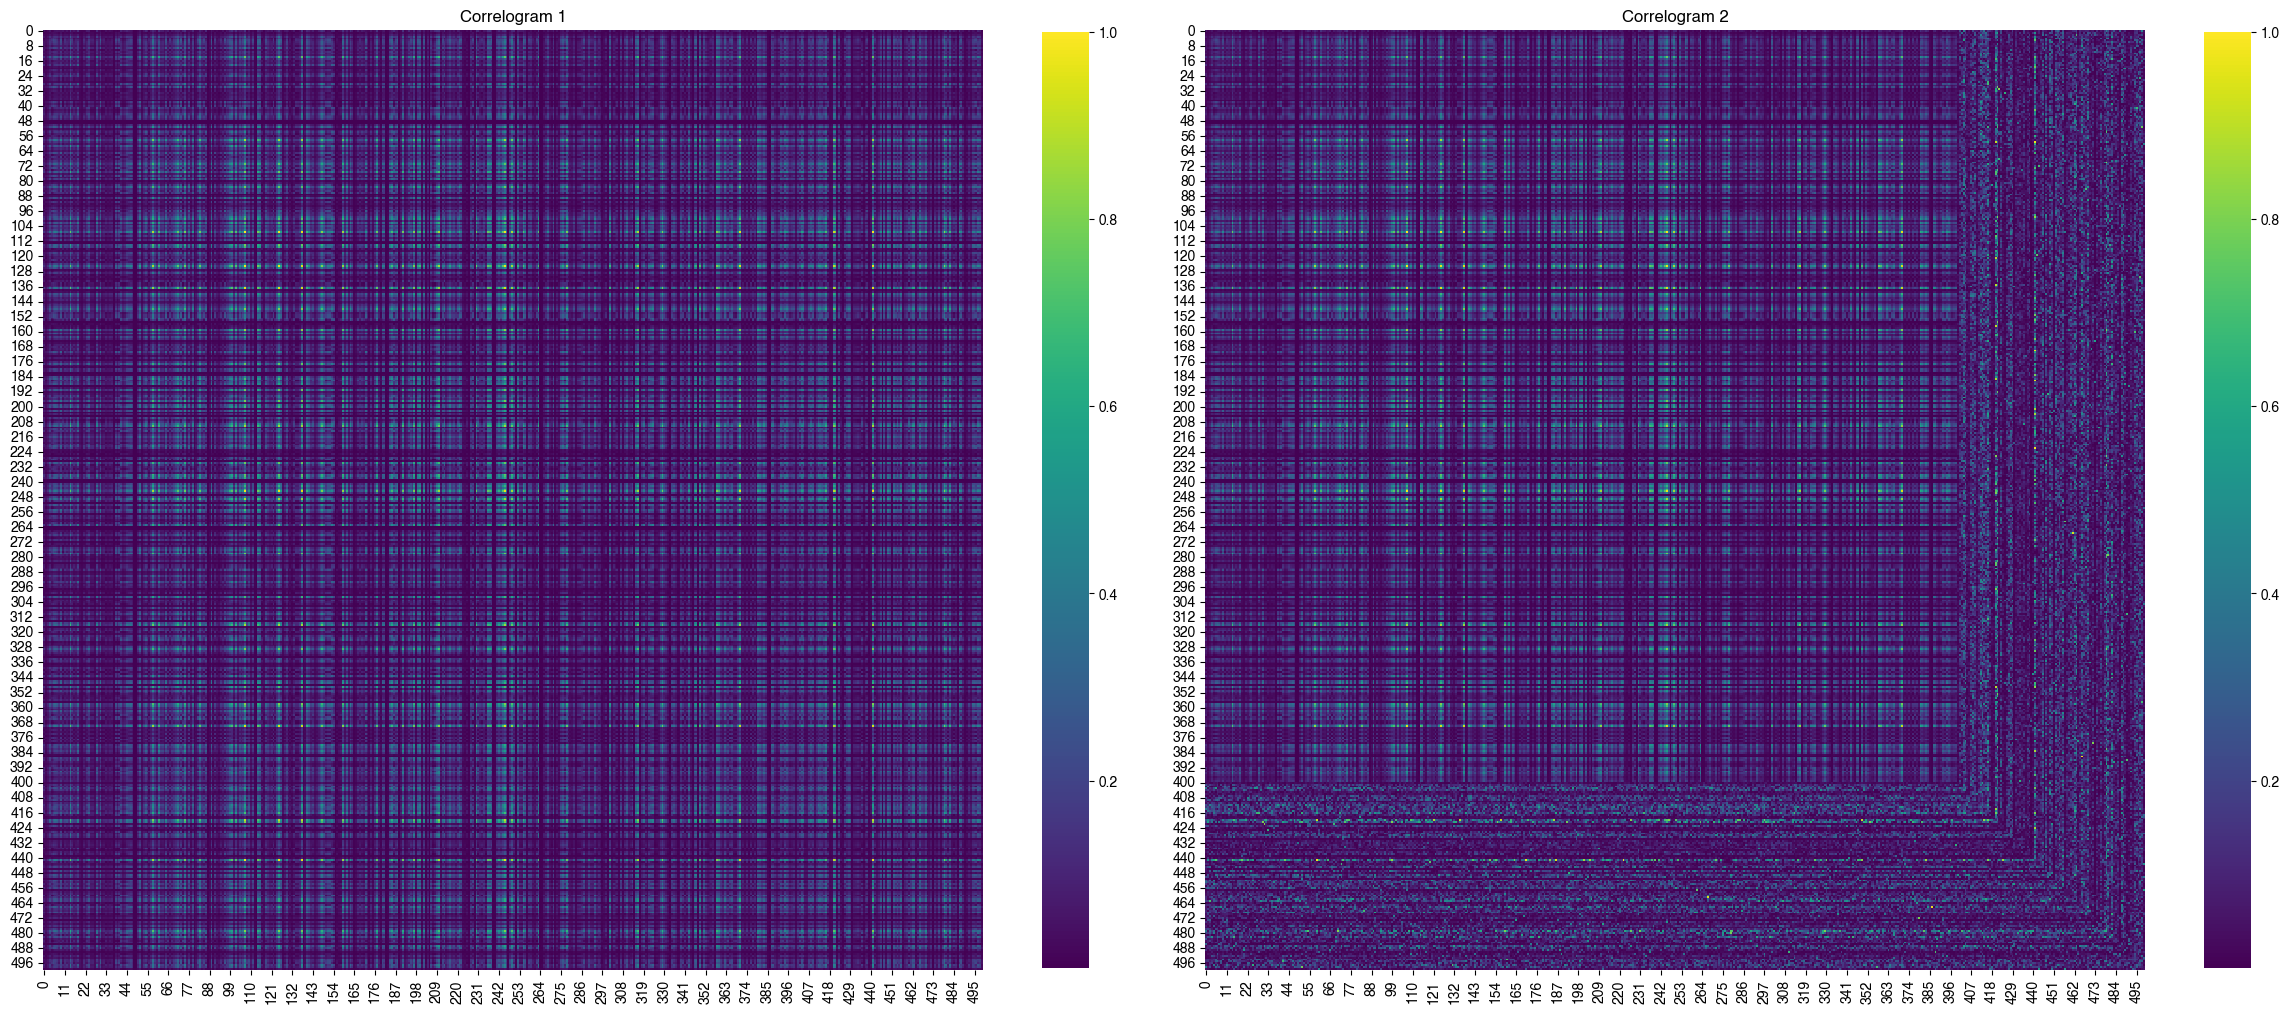

<module 'matplotlib.pyplot' from '/Users/aldric-l/Library/Python/3.11/lib/python/site-packages/matplotlib/pyplot.py'>

In [48]:
plot_correlogram(true_comp_matrix, fake_comp_matrix)

In [49]:
from scipy.stats import gaussian_kde
def plot_density(*vectors, titles=None, savefile=None):
    """
    Plots multiple density plots in a row as subplots.

    Args:
        *vectors: Variable number of lists or NumPy arrays representing the data.
        titles: Optional list of titles for each density plot. If None, default titles are used.
    """

    num_vectors = len(vectors)

    if num_vectors == 0:
        print("No vectors provided.")
        return

    if titles is None:
        titles = [f"Density Plot {i+1}" for i in range(num_vectors)]
    elif len(titles) != num_vectors:
        print("Number of titles does not match number of vectors.")
        titles = [f"Density Plot {i+1}" for i in range(num_vectors)]

    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Helvetica', 'Arial', 'DejaVu Sans']
    plt.figure(figsize=(10 * num_vectors, 5))

    for i, vector in enumerate(vectors):
        if not isinstance(vector, (list, np.ndarray)):
            raise TypeError(f"Input vector {i+1} must be a list or numpy array.")

        if isinstance(vector, list) and not isinstance(vector, np.ndarray):
            vector = np.array(vector)

        plt.subplot(1, num_vectors, i + 1)
        sns.kdeplot(vector, fill=True)
        plt.title(titles[i])
        plt.xlabel("Value")
        plt.ylabel("Density")
        plt.grid(True)

    plt.tight_layout()
    if savefile is not None:
        plt.savefig(savefile + ".eps", bbox_inches='tight')
    plt.show()
    return plt

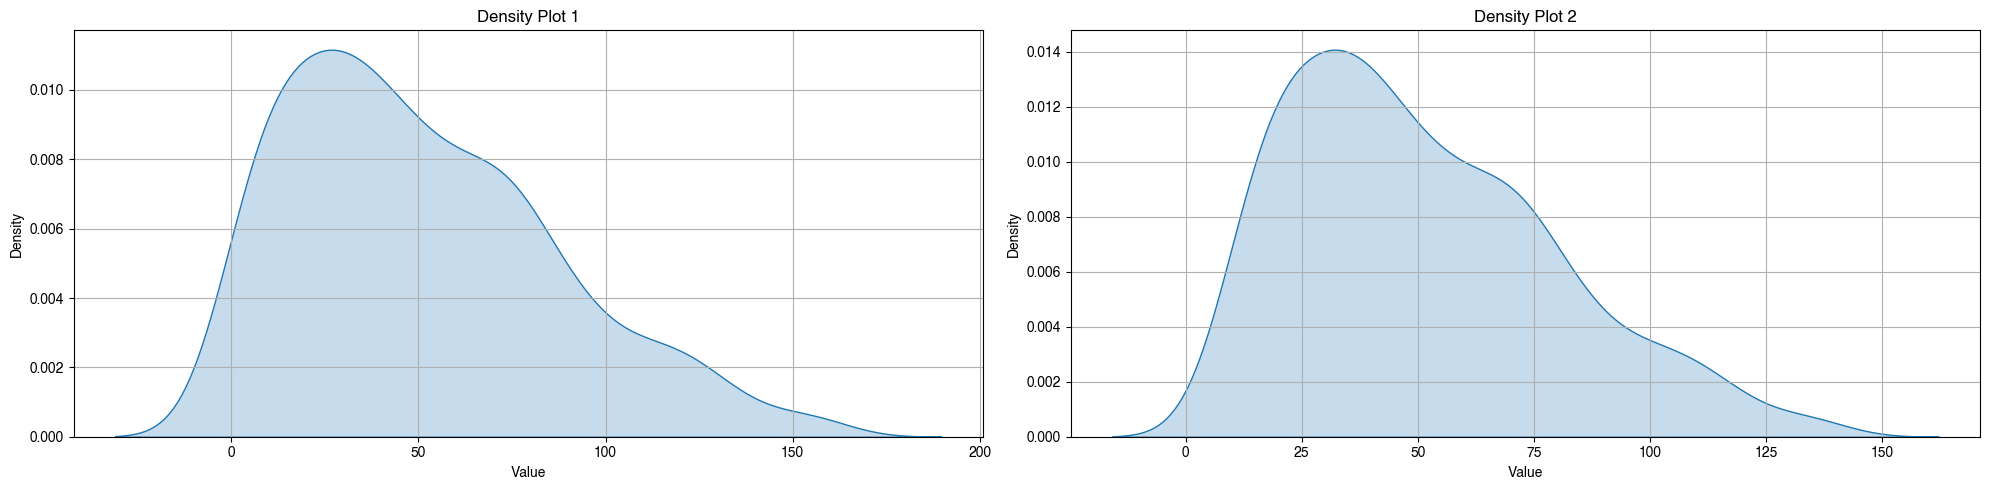

<module 'matplotlib.pyplot' from '/Users/aldric-l/Library/Python/3.11/lib/python/site-packages/matplotlib/pyplot.py'>

In [50]:
plot_density(np.sum(true_comp_matrix, axis=0), np.sum(fake_comp_matrix, axis=0))

In [51]:
np.savetxt("wavy4_comp_matrix.csv", fake_comp_matrix, fmt='%.6f', delimiter=',')
np.savetxt("wavy4_p_matrix.csv", wavy_vectors, fmt='%.6f', delimiter=',')
np.savetxt("wavy4_true_p_matrix.csv", seed_vectors, fmt='%.6f', delimiter=',')

4c is the same as 4b but with higher precision. 4a was not having sufficiently many links.

### WAVY5

The idea is to produce affinities using a RBF kernel


In [ ]:
seed_vectors.shape[0]

(500, 2)

In [9]:
dist = np.zeros(shape=(seed_vectors.shape[0], seed_vectors.shape[0]))

In [10]:
for i in range(seed_vectors.shape[0]):
    for j in range(seed_vectors.shape[0]):
        dist[i,j] = np.exp(-((seed_vectors[i][0] - seed_vectors[j][0]) **2 + (seed_vectors[i][1] - seed_vectors[j][1])**2)**0.5)

In [12]:
np.fill_diagonal(dist, 0)

In [13]:
dist

array([[0.        , 0.00825863, 0.25227861, ..., 0.22876511, 0.16755032,
        0.13394732],
       [0.00825863, 0.        , 0.0093949 , ..., 0.00194728, 0.01150986,
        0.00118835],
       [0.25227861, 0.0093949 , 0.        , ..., 0.08790373, 0.0488481 ,
        0.05093629],
       ...,
       [0.22876511, 0.00194728, 0.08790373, ..., 0.        , 0.08432794,
        0.57368067],
       [0.16755032, 0.01150986, 0.0488481 , ..., 0.08432794, 0.        ,
        0.06311049],
       [0.13394732, 0.00118835, 0.05093629, ..., 0.57368067, 0.06311049,
        0.        ]])

In [ ]:
import random

def shuffle_symmetric_matrix(matrix: list[list[any]], k: int) -> list[list[any]]:
    """
    Shuffles the elements within the last k columns of a square matrix
    and propagates the changes to the corresponding rows to maintain symmetry.

    Args:
        matrix: A square matrix (list of lists) of any type.
        k: The number of last columns to shuffle.

    Returns:
        The modified symmetric matrix with the last k columns and
        corresponding rows shuffled.

    Raises:
        ValueError: If the matrix is not square or if k is an invalid value.
    """
    matrix = np.copy(matrix)
    try:
        n = len(matrix)
        if n == 0 or any(len(row) != n for row in matrix):
            raise ValueError("Input matrix must be a non-empty square matrix.")

        if not (0 <= k <= n):
            raise ValueError(f"k must be an integer between 0 and {n}.")

        # Iterate over the last k columns
        for j in range(n - k, n):
            # 1. Extract the elements of the current column
            column_elements = [matrix[i][j] for i in range(n)]

            # 2. Randomly shuffle the elements
            random.shuffle(column_elements)

            # 3. Update the original matrix column with the shuffled elements
            for i in range(n):
                matrix[i][j] = column_elements[i]

            # 4. Propagate the changes to the corresponding row to maintain symmetry
            for i in range(n):
                matrix[j][i] = matrix[i][j]

        return matrix

    except Exception as e:
        print(f"An error occurred: {e}")
        return None
    


In [17]:
fake_dist = shuffle_symmetric_matrix(dist, 100)

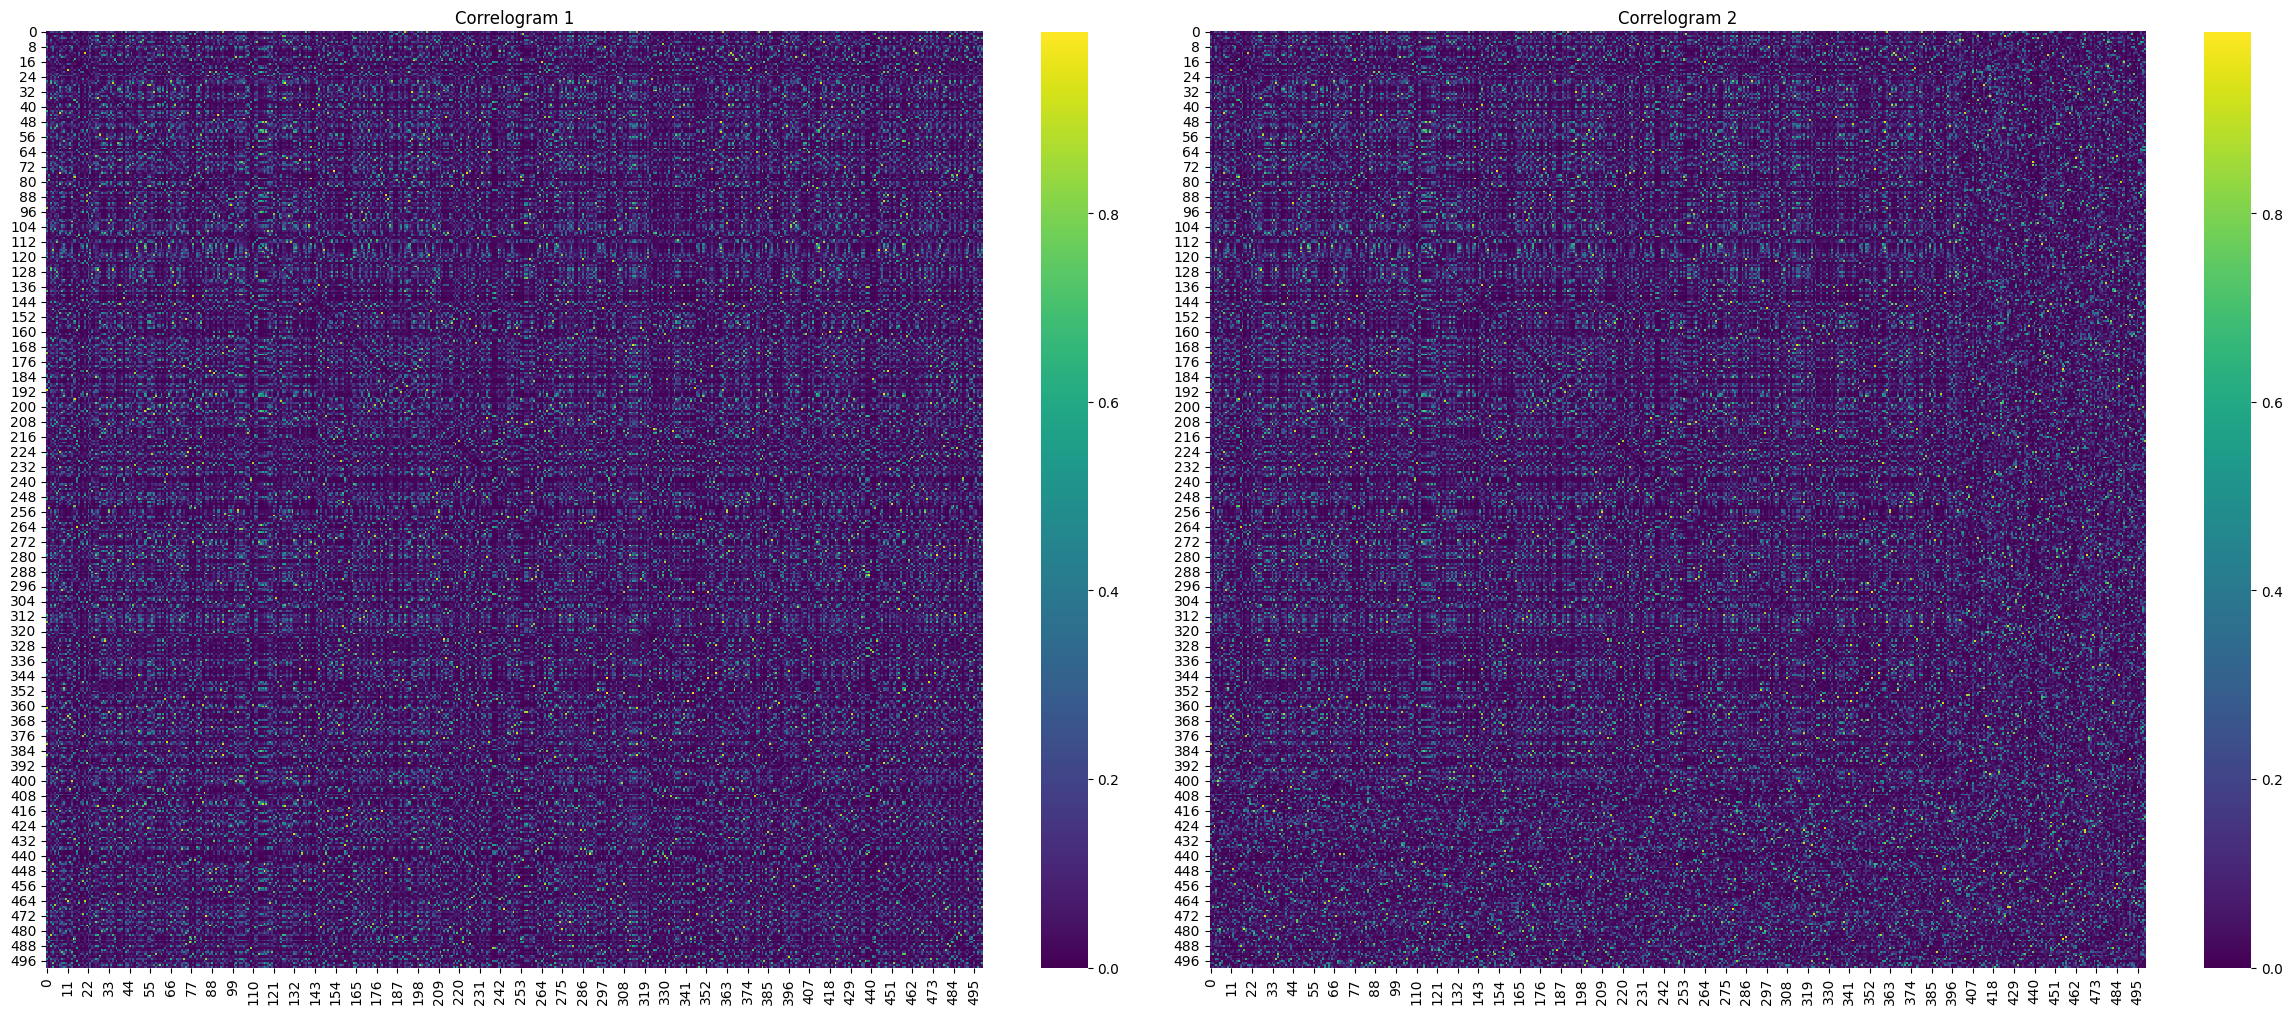

<module 'matplotlib.pyplot' from '/Users/aldric-l/Library/Python/3.11/lib/python/site-packages/matplotlib/pyplot.py'>

In [18]:
plot_correlogram(dist, fake_dist)

In [19]:
np.savetxt("wavy5_true_comp_matrix.csv", dist, fmt='%.6f', delimiter=',')
np.savetxt("wavy5_comp_matrix.csv", fake_dist, fmt='%.6f', delimiter=',')
np.savetxt("wavy5_p_matrix.csv", wavy_vectors, fmt='%.6f', delimiter=',')
np.savetxt("wavy5_true_p_matrix.csv", seed_vectors, fmt='%.6f', delimiter=',')